In [ ]:
import arcpy
from arcpy import env
import os
from arcgis import GIS
from arcgis.features import GeoAccessor
from dfply import *
import pandas as pd

arcpy.env.overwriteOutput = True
arcpy.env.parallelProcessingFactor = "90%"

# show all columns
pd.options.display.max_columns = None

# pd.DataFrame.spatial.from_featureclass(???)
# df.spatial.to_featureclass(location=???,sanitize_columns=False)

In [ ]:
if not os.path.exists('Outputs'):
    os.makedirs('Outputs')
    
outputs = ['.\\Outputs', "scratch.gdb", 'results.gdb']
gdb = os.path.join(outputs[0], outputs[1])
gdb2 = os.path.join(outputs[0], outputs[2])

if not arcpy.Exists(gdb):
    arcpy.CreateFileGDB_management(outputs[0], outputs[1])

if not arcpy.Exists(gdb2):
    arcpy.CreateFileGDB_management(outputs[0], outputs[2])

In [ ]:
#gis = GIS("https://arcgis.com", "user_name")
gis = GIS("https://arcgis.com", "cday_wfrc")
print("connected")

In [ ]:
def get_monthly_usage(gismap, year):
    map = pd.DataFrame(gismap.usage("1Y")) 
    map['MapName'] = gismap.title
    map['Year'] = pd.DatetimeIndex(map['Date']).year
    map['Month'] = pd.DatetimeIndex(map['Date']).month
    map['Day'] = pd.DatetimeIndex(map['Date']).day
    map = (map >>
        mask(X.Year == year) >>
        group_by(X.Month, X.Year, X.MapName) >>
        summarize(monthlyUsage = X.Usage.sum())
    )
    return map

<Item title:"Active Transportation GIS Data Resources" type:Web Mapping Application owner:msilski_wfrcgis>
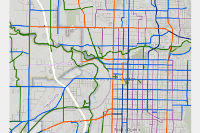

In [ ]:
activeMap = gis.content.get('87827ba730d44a09aeeae83a8f9dc43e')
activeMap

In [ ]:
activeMapDT = get_monthly_usage(activeMap, 2022)
activeMapDT

,MapName,Year,Month,monthlyUsage
0,Active Transportation GIS Data Resources,2022,1,121
1,Active Transportation GIS Data Resources,2022,2,116
2,Active Transportation GIS Data Resources,2022,3,80
3,Active Transportation GIS Data Resources,2022,4,65
4,Active Transportation GIS Data Resources,2022,5,111
5,Active Transportation GIS Data Resources,2022,6,108


In [ ]:
#print(activeMapDT['Year'])

In [ ]:
MinorityTable = (minority >>
    tail(minority.shape[0] - 1) >>
    rename(Population=X.B03002_001E,White_E=X.B03002_003E,White_M=X.B03002_003M) >>
    mutate(Population = (X.Population).astype(float),
           White_E = (X.White_E).astype(float),
           White_M = (X.White_M).astype(float)
          ) >>
    mutate(Minority = X.Population - X.White_E) >>
    mutate(PercMinori = (X.Minority/X.Population).round(3)) >>
    select("NAME","GEO_ID","Population","Minority","PercMinori") >>
    mutate(Perc_Minorit = if_else(X.PercMinori > 0.4,1,0))
)